In [7]:
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [76]:
tasks_fn = 'resources/house_target_tuple.json'

with open(tasks_fn, 'r') as f:
    house_target_tuple = json.load(f)

In [77]:
# Enumerate distances inside of task tuple data.
task_ds = []
for house in house_target_tuple:
    for _, _, _, _, end_pano_ds in house_target_tuple[house]:
        task_ds.append(min(end_pano_ds))

In [78]:
# Enumrate distances inside of matterport R2R data.
mp_ds = []
for fn in ['../../../tasks/R2R/data/R2R_train.json',
           '../../../tasks/R2R/data/R2R_val_seen.json',
           '../../../tasks/R2R/data/R2R_val_unseen.json']:
    with open(fn, 'r') as f:
        mp_data = json.load(f)
    for trajectory in mp_data:
        mp_ds.append(len(trajectory['path']))

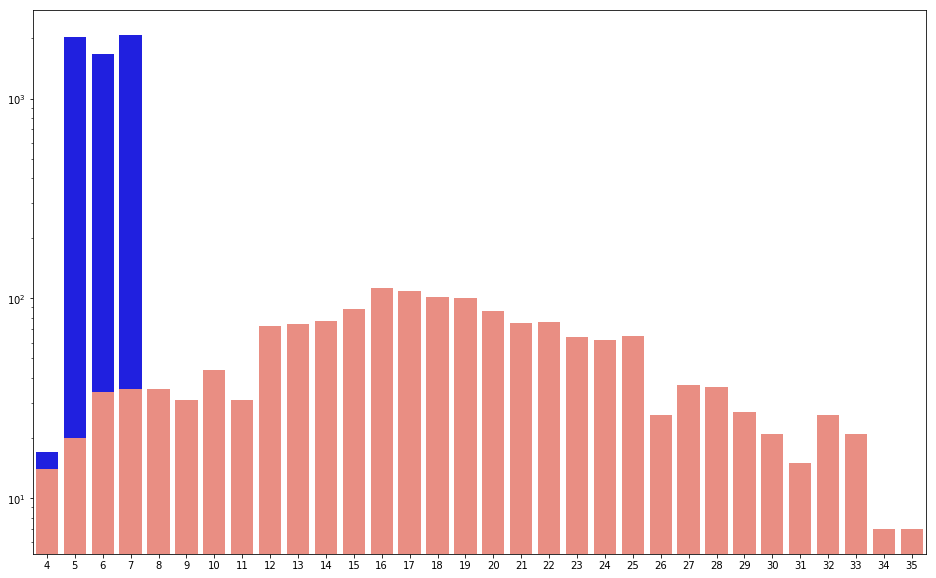

1629
18.210558624923266 6.6787541612565535
4.853050302410159 31.56806694743637
5798
6.002414625733011 0.8492805017698207
4.30385362219337 7.700975629272652


In [80]:
# Visualize tuple path distances.
bin_size = 1

freq_of_task_ds_count_bins = {}
for c in task_ds:
    cbin = c // bin_size
    if cbin not in freq_of_task_ds_count_bins:
        freq_of_task_ds_count_bins[cbin] = 0
    freq_of_task_ds_count_bins[cbin] += 1
for cbin in range(min(freq_of_task_ds_count_bins), max(freq_of_task_ds_count_bins)):
    if cbin not in freq_of_task_ds_count_bins:
        freq_of_task_ds_count_bins[cbin] = 0

freq_of_mp_ds_count_bins = {}
for c in mp_ds:
    cbin = c // bin_size
    if cbin not in freq_of_mp_ds_count_bins:
        freq_of_mp_ds_count_bins[cbin] = 0
    freq_of_mp_ds_count_bins[cbin] += 1
for cbin in range(min(freq_of_mp_ds_count_bins), max(freq_of_mp_ds_count_bins)):
    if cbin not in freq_of_task_ds_count_bins:
        freq_of_task_ds_count_bins[cbin] = 0
for cbin in range(min(freq_of_task_ds_count_bins), max(freq_of_task_ds_count_bins)):
    if cbin not in freq_of_mp_ds_count_bins:
        freq_of_mp_ds_count_bins[cbin] = 0

fig, ax = plt.subplots(figsize=(16, 10))
g1 = sns.barplot(ax=ax,
                 x=[k * bin_size for k in freq_of_mp_ds_count_bins],
                 y=[freq_of_mp_ds_count_bins[k] for k in freq_of_mp_ds_count_bins],
                 color="blue")
g2 = sns.barplot(ax=ax,
                 x=[k * bin_size for k in freq_of_task_ds_count_bins],
                 y=[freq_of_task_ds_count_bins[k] for k in freq_of_task_ds_count_bins],
                 color="salmon")
ax.set(yscale="log")
plt.show()

mean = np.mean(task_ds)
stddev = np.std(task_ds)
print(len(task_ds))
print(mean, stddev)
print(mean-2*stddev, mean+2*stddev)

mean = np.mean(mp_ds)
stddev = np.std(mp_ds)
print(len(mp_ds))
print(mean, stddev)
print(mean-2*stddev, mean+2*stddev)